# Nutrition Assistant Evaluation

This notebook evaluates the current USDA + LLM chatbot on practical assistant metrics:

- routing / intent behavior
- source selection behavior
- latency
- correction recovery
- memory recall behavior
- structured response coverage

It uses heuristic checks plus labeled examples from `evaluation/eval_cases.jsonl`.

In [1]:
from pathlib import Path
import asyncio
import json
import statistics
import time
import sys
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from typing import Dict, List

ROOT = Path.cwd().resolve()
if ROOT.name == 'notebooks':
    ROOT = ROOT.parent
sys.path.insert(0, str(ROOT))

from app.services.assistant_service import AssistantService

service = AssistantService()
cases_path = ROOT / 'evaluation' / 'eval_cases.jsonl'
cases = [json.loads(line) for line in cases_path.read_text(encoding='utf-8').splitlines() if line.strip()]
print(f'Loaded {len(cases)} eval cases from {cases_path}')


Loaded 26 eval cases from C:\Users\jazg2\Downloads\LLama_experiment\internal_bot\opencommerce-ai-assistant\evaluation\eval_cases.jsonl


In [2]:
def synthetic_history(case_id: str):
    if case_id == 'memory_001':
        return [
            {'role': 'user', 'content': 'Compare Snickers and Kit Kat to see which is less calorie dense'},
            {'role': 'assistant', 'content': '[source: llm + usda-compare] ...'},
            {'role': 'user', 'content': 'Can you tell me the nutrition facts for a Monster energy drink?'},
            {'role': 'assistant', 'content': '[source: llm + usda] ...'},
        ]
    if case_id == 'memory_002':
        return [
            {'role': 'user', 'content': 'Compare Coke Zero and Pepsi for sugar'},
            {'role': 'assistant', 'content': '[source: llm + usda-compare] ...'},
        ]
    if case_id == 'correction_001':
        return [
            {'role': 'user', 'content': 'Tell me the nutrition facts for a Snickers bar'},
            {'role': 'assistant', 'content': '[source: llm + usda] ...'},
        ]
    return []

def expected_mode_ok(expected_mode: str, extracted_mode: str) -> bool:
    if expected_mode == 'greeting':
        return True
    if expected_mode == 'catalog_or_disambiguation':
        return extracted_mode in {'catalog', 'compare'}
    if expected_mode == 'clarification_or_compare':
        return extracted_mode in {'general', 'compare'}
    return extracted_mode == expected_mode

def expected_source_ok(expected_source: str, response_text: str) -> bool:
    return response_text.startswith(expected_source)

def keywords_ok(must_contain: List[str], response_text: str) -> bool:
    lowered = response_text.lower()
    return all(token.lower() in lowered for token in must_contain)

def normalized_mode(service, user_input: str) -> str:
    lowered = user_input.strip().lower()
    if lowered in {'hi', 'hello', 'hey', 'hola', 'buenas', 'ola'}:
        return 'greeting'
    extracted = service.chat.extract_food_query(user_input, use_history=False)
    if service.chat.is_natural_food_request(extracted):
        extracted['mode'] = 'general'
    elif extracted.get('mode') in {'general', 'catalog'} and service._should_force_catalog_mode(user_input):
        extracted['mode'] = 'catalog'
    return extracted.get('mode', 'unknown')

async def run_case(case: Dict):
    history = synthetic_history(case['id'])
    user_input = case['user_input']
    extracted_mode = normalized_mode(service, user_input)

    t0 = time.perf_counter()
    response = await service.answer(user_input, history=history)
    latency_ms = (time.perf_counter() - t0) * 1000

    return {
        'id': case['id'],
        'expected_mode': case['expected_mode'],
        'extracted_mode': extracted_mode,
        'mode_pass': expected_mode_ok(case['expected_mode'], extracted_mode),
        'expected_source': case['expected_source'],
        'source_pass': expected_source_ok(case['expected_source'], response),
        'keyword_pass': keywords_ok(case['must_contain'], response),
        'latency_ms': latency_ms,
        'response': response,
        'notes': case['notes'],
    }


async def run_all_cases_sequential(cases: List[Dict]):
    results = []
    for case in cases:
        results.append(await run_case(case))
    return results


In [3]:
cases = [json.loads(line) for line in cases_path.read_text(encoding='utf-8').splitlines() if line.strip()]
print(f'Running {len(cases)} cases')
print('Evaluation mode: sequential')
results = await run_all_cases_sequential(cases)
len(results)


Running 26 cases
Evaluation mode: sequential
[DEBUG][SERVICE] user_text='Hello'
[DEBUG][SERVICE] user_text='Can you tell me the nutrition facts for a Monster energy drink?'
[DEBUG][SERVICE] extracted_mode='catalog' extracted_query='monster energy drink' compare_items=[] goal='lower calories'
[DEBUG][USDA] status=200 url=https://api.nal.usda.gov/fdc/v1/foods/search?api_key=1Gr99ZrmSscbvIaf1jZqvPsRnxngY97xSiiHQta5 query='monster energy drink'
[DEBUG][USDA] returned_products=12 query='monster energy drink'
[DEBUG][SERVICE] products=12 source='usda' error='' status=200
[DEBUG][SERVICE] response_source='llm + usda'
[DEBUG][SERVICE] user_text='Compare Snickers and Kit Kat to see which is less calorie dense'
[DEBUG][SERVICE] extracted_mode='compare' extracted_query='snickers kit kat calorie density' compare_items=['snickers chocolate bar', 'kit kat'] goal='lower calories'
[DEBUG][USDA] status=200 url=https://api.nal.usda.gov/fdc/v1/foods/search?api_key=1Gr99ZrmSscbvIaf1jZqvPsRnxngY97xSiiHQta5

[DEBUG][SERVICE] user_text='Find me a lower sugar energy drink option'
[DEBUG][SERVICE] extracted_mode='catalog' extracted_query='lower sugar energy drink options' compare_items=[] goal='lower sugar'
[DEBUG][USDA] status=200 url=https://api.nal.usda.gov/fdc/v1/foods/search?api_key=1Gr99ZrmSscbvIaf1jZqvPsRnxngY97xSiiHQta5 query='lower sugar energy drink options'
[DEBUG][USDA] returned_products=12 query='lower sugar energy drink options'
[DEBUG][SERVICE] products=12 source='usda' error='' status=200
[DEBUG][SERVICE] response_source='llm + usda'
[DEBUG][SERVICE] user_text='Show me a lower sodium soup product'
[DEBUG][SERVICE] extracted_mode='catalog' extracted_query='low sodium soup' compare_items=[] goal='lower sodium'
[DEBUG][USDA] status=200 url=https://api.nal.usda.gov/fdc/v1/foods/search?api_key=1Gr99ZrmSscbvIaf1jZqvPsRnxngY97xSiiHQta5 query='low sodium soup'
[DEBUG][USDA] returned_products=12 query='low sodium soup'
[DEBUG][SERVICE] products=12 source='usda' error='' status=200
[DEB

26

In [4]:
latencies = [r['latency_ms'] for r in results]
summary = {
    'case_count': len(results),
    'routing_accuracy': sum(r['mode_pass'] for r in results) / len(results),
    'source_behavior_accuracy': sum(r['source_pass'] for r in results) / len(results),
    'keyword_constraint_rate': sum(r['keyword_pass'] for r in results) / len(results),
    'overall_case_pass_rate': sum((r['mode_pass'] and r['source_pass'] and r['keyword_pass']) for r in results) / len(results),
    'avg_latency_ms': statistics.mean(latencies),
    'median_latency_ms': statistics.median(latencies),
    'p95_latency_ms': sorted(latencies)[max(0, int(len(latencies) * 0.95) - 1)],
}
summary

{'case_count': 26,
 'routing_accuracy': 1.0,
 'source_behavior_accuracy': 1.0,
 'keyword_constraint_rate': 1.0,
 'overall_case_pass_rate': 1.0,
 'avg_latency_ms': 7072.580119230766,
 'median_latency_ms': 8313.928599999996,
 'p95_latency_ms': 11905.883500000002}

In [5]:
for r in results:
    if not (r['mode_pass'] and r['source_pass'] and r['keyword_pass']):
        print('=' * 100)
        print(r['id'])
        print('expected_mode:', r['expected_mode'], '| extracted_mode:', r['extracted_mode'])
        print('mode_pass:', r['mode_pass'], 'source_pass:', r['source_pass'], 'keyword_pass:', r['keyword_pass'])
        print('latency_ms:', round(r['latency_ms'], 1))
        print('notes:', r['notes'])
        print('response preview:')
        print(r['response'][:1200])


In [6]:
from collections import defaultdict
bucketed = defaultdict(list)
for r in results:
    prefix = r['id'].split('_')[0]
    bucketed[prefix].append(r)
bucket_summary = {}
for prefix, rows in bucketed.items():
    bucket_summary[prefix] = {
        'count': len(rows),
        'overall_pass_rate': sum((x['mode_pass'] and x['source_pass'] and x['keyword_pass']) for x in rows) / len(rows),
        'avg_latency_ms': sum(x['latency_ms'] for x in rows) / len(rows),
    }
bucket_summary


{'greet': {'count': 1,
  'overall_pass_rate': 1.0,
  'avg_latency_ms': 0.08270000000010214},
 'single': {'count': 6,
  'overall_pass_rate': 1.0,
  'avg_latency_ms': 8059.395516666668},
 'compare': {'count': 7,
  'overall_pass_rate': 1.0,
  'avg_latency_ms': 7694.590728571428},
 'general': {'count': 1,
  'overall_pass_rate': 1.0,
  'avg_latency_ms': 2046.0144999999984},
 'memory': {'count': 2,
  'overall_pass_rate': 1.0,
  'avg_latency_ms': 2288.2126499999986},
 'correction': {'count': 1,
  'overall_pass_rate': 1.0,
  'avg_latency_ms': 10191.472999999994},
 'goal': {'count': 2,
  'overall_pass_rate': 1.0,
  'avg_latency_ms': 7737.507049999995},
 'disambiguation': {'count': 1,
  'overall_pass_rate': 1.0,
  'avg_latency_ms': 8452.682199999997},
 'catalog': {'count': 4,
  'overall_pass_rate': 1.0,
  'avg_latency_ms': 9938.52239999999},
 'clarification': {'count': 1,
  'overall_pass_rate': 1.0,
  'avg_latency_ms': 1172.7934999999832}}

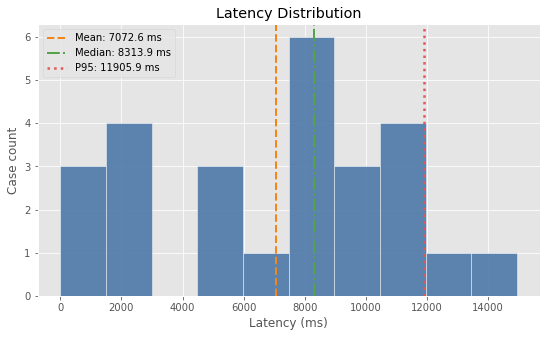

In [7]:
latencies = [r['latency_ms'] for r in results]
mean_latency = statistics.mean(latencies)
median_latency = statistics.median(latencies)
p95_latency = sorted(latencies)[max(0, int(len(latencies) * 0.95) - 1)]

fig, ax = plt.subplots(figsize=(9, 5))
ax.hist(latencies, bins=min(10, max(5, len(latencies)//2)), color='#4C78A8', edgecolor='white', alpha=0.9)
ax.axvline(mean_latency, color='#F58518', linestyle='--', linewidth=2, label=f'Mean: {mean_latency:.1f} ms')
ax.axvline(median_latency, color='#54A24B', linestyle='-.', linewidth=2, label=f'Median: {median_latency:.1f} ms')
ax.axvline(p95_latency, color='#E45756', linestyle=':', linewidth=2.5, label=f'P95: {p95_latency:.1f} ms')
ax.set_title('Latency Distribution')
ax.set_xlabel('Latency (ms)')
ax.set_ylabel('Case count')
ax.legend()
plt.show()


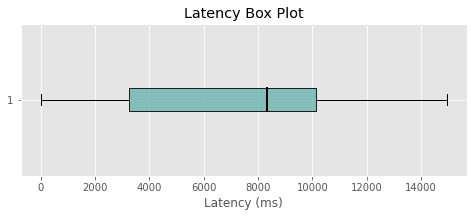

In [8]:
fig, ax = plt.subplots(figsize=(8, 2.8))
ax.boxplot(latencies, vert=False, patch_artist=True, boxprops=dict(facecolor='#72B7B2', alpha=0.85), medianprops=dict(color='black', linewidth=2))
ax.set_title('Latency Box Plot')
ax.set_xlabel('Latency (ms)')
plt.show()


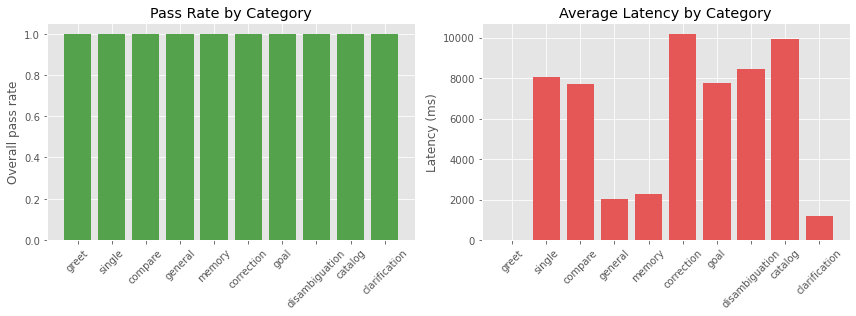

In [9]:
labels = list(bucket_summary.keys())
pass_rates = [bucket_summary[k]['overall_pass_rate'] for k in labels]
avg_lat = [bucket_summary[k]['avg_latency_ms'] for k in labels]

fig, axes = plt.subplots(1, 2, figsize=(12, 4.5))
axes[0].bar(labels, pass_rates, color='#54A24B')
axes[0].set_ylim(0, 1.05)
axes[0].set_title('Pass Rate by Category')
axes[0].set_ylabel('Overall pass rate')
axes[0].tick_params(axis='x', rotation=45)

axes[1].bar(labels, avg_lat, color='#E45756')
axes[1].set_title('Average Latency by Category')
axes[1].set_ylabel('Latency (ms)')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


## Suggested metrics to report in the portfolio

- **Routing accuracy**: whether current-turn requests are sent to the right behavior path (`catalog`, `compare`, `general`, `memory`, `correction`).
- **Source behavior accuracy**: whether packaged-product questions produce USDA-backed answers and greetings/clarifications behave correctly.
- **Constraint/format compliance**: whether required sections like `Comparison table`, `Assumed goal`, or menu prompts appear.
- **Latency**: average / median / p95 response time.
- **Correction recovery rate**: proportion of correction prompts that recover to the prior actionable task.
- **Memory recall rate**: whether earlier discussed products are accurately summarized from session state.

For a stronger future version, add human labels for factual accuracy and a grounded numeric consistency check against USDA nutrient values.